In [1]:
!ls ../resources/context_filter

nodecoder_test_0  nodecoder_train_0  nodecoder_val_0  test_0  train_0  valid_0


In [6]:
!ln -s ../context_nmt ./

In [1]:
train_path = '/home/litong/context_translation/resources/train_77b9dbd0538187438b8dd13a8f6b935c.pkl'
valid_path = '/home/litong/context_translation/resources/valid_0a06896723176aff827aac15a2e1ac94.pkl'
test_path = '/home/litong/context_translation/resources/test_3c5cba7d2f64b7fb2d6b5013adc7a888.pkl'

In [4]:
filtered_context = '/home/litong/context_translation/resources/context_filter/jiji_context_filter_en_ja_0'
nodecoder_filtered_context = '/home/litong/context_translation/resources/context_filter/jiji_context_filter_nodecoder_en_ja_0'

In [2]:
import random
import pickle
from context_nmt.data.dataset_readers.context_translation_dataset_reader import read_context_index_file

# Plot some graphs

In [5]:
context_pairs = read_context_index_file(filtered_context)

In [6]:
nodecoder_context_pairs = read_context_index_file(nodecoder_filtered_context)

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

def get_counter(pairs):
    counter = Counter()
    for _, doc in pairs.items():
        for sent_id, (cs_id, score) in doc.items():
            if cs_id == -1:
                counter[-1] += 1
            else:
                counter[sent_id - cs_id] += 1
    return counter

In [12]:
print(sum([len(doc) for doc in context_pairs.values()]))
print(sum(map(sum, [[context_pairs[d_id][s_id][0] != nodecoder_context_pairs[d_id][s_id][0] for s_id in doc] for d_id, doc in context_pairs.items()])))

815389
238104


In [14]:
counter, nodecoder_counter = [get_counter(pairs) for pairs in (context_pairs, nodecoder_context_pairs)]

In [17]:
sum(counter.values()) == sum(nodecoder_counter.values())

True

<BarContainer object of 6 artists>

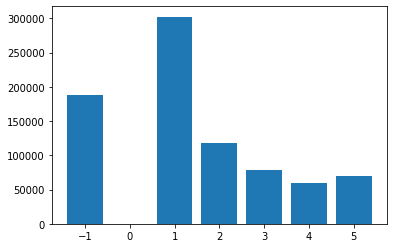

In [15]:
plt.bar(counter.keys(), counter.values())

<BarContainer object of 6 artists>

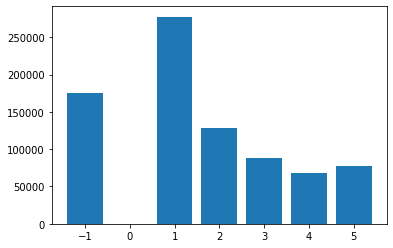

In [16]:
plt.bar(nodecoder_counter.keys(), nodecoder_counter.values())

From the results generated from the first iteration of BERT fine-tuning, we can find that proposed method is picking out more one sentence before and no context than the baseline nomarl BERT fine-tuning. On the other, they have similiar distribution on the picked previous sentnces other than the one before.

In [9]:
with open(test_path, 'rb') as source:
    test_data = pickle.load(source)
with open(valid_path, 'rb') as source:
    valid_data = pickle.load(source)

In [24]:
def get_pairs(data, context_pairs, lang="en"):
    def get_pair(doc_id, sent_id):
        context_index = context_pairs[doc_id][sent_id][0]
        if context_index == -1:
            context = ""
        else:
            context = data[doc_id][lang][context_index]
        sent = data[doc_id][lang][sent_id]
        return (context_index, sent_id, context, sent)
    pairs = []
    for doc_id, doc in data.items():
        for sent_id, score in doc["pairs"]:
            pairs.append(get_pair(doc_id, sent_id))
    return pairs

# No Decoder

In [31]:
nd_valid_cp = read_context_index_file('../resources/context_filter/nodecoder_val_0')
nd_valid_pairs = get_pairs(valid_data, nd_valid_cp)
nd_test_cp = read_context_index_file('../resources/context_filter/nodecoder_test_0')
nd_test_pairs = get_pairs(test_data, nd_test_cp)

# With Decoder

In [33]:
valid_cp = read_context_index_file('../resources/context_filter/valid_0')
valid_pairs = get_pairs(valid_data, valid_cp)
test_cp = read_context_index_file('../resources/context_filter/test_0')
test_pairs = get_pairs(test_data, test_cp)

In [34]:
val_indexs = [random.randint(0, len(nd_valid_pairs)) for _ in range(10)]
test_indexs = [random.randint(0, len(nd_test_pairs)) for _ in range(10)]

In [35]:
print(val_indexs)
print(test_indexs)

[104, 898, 1656, 1716, 653, 111, 1383, 1266, 42, 798]
[1777, 1524, 1308, 1514, 1543, 1731, 1642, 1238, 230, 460]


In [40]:
print(sum([valid[0] != nd_valid[0] for valid, nd_valid in zip(valid_pairs, nd_valid_pairs)]))
print(len(valid_pairs))

979
2051


In [41]:
print(sum([test[0] != nd_test[0] for test, nd_test in zip(test_pairs, nd_test_pairs)]))
print(len(test_pairs))

1019
2120


In [42]:
import sacrebleu

In [56]:
help(sacrebleu.corpus_bleu)

Help on function corpus_bleu in module sacrebleu:

corpus_bleu(sys_stream: Union[str, Iterable[str]], ref_streams: Union[str, List[Iterable[str]]], smooth_method='exp', smooth_value=0.0, force=False, lowercase=False, tokenize='13a', use_effective_order=False) -> sacrebleu.BLEU
    Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_value: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want

